In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Concatenate, Attention, MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import os

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration dictionary for maintainability
CONFIG = {
    'features': [
        {'name': 'close_lag', 'column': 'Close', 'type': 'lag', 'params': {'lag': [1, 2, 3, 5]}},
        {'name': 'volume_lag', 'column': 'Volume', 'type': 'lag', 'params': {'lag': [1, 2, 5]}},

        {'name': 'close_return', 'column': 'Close', 'type': 'return', 'params': {'lag': [1, 5, 10]}},

        # {'name': 'close_ma', 'column': 'Close', 'type': 'ma', 'params': {'window': [5, 10, 20]}},
        {'name': 'close_ema', 'column': 'Close', 'type': 'ema', 'params': {'span': [12, 26]}},

        {'name': 'rsi', 'column': 'Close', 'type': 'rsi', 'params': {'window': 9}},
        {'name': 'rsi', 'column': 'Close', 'type': 'rsi', 'params': {'window': 14}},

        {'name': 'bollinger', 'column': 'Close', 'type': 'bollinger', 'params': {'window': 10, 'std': 1.5}},
        {'name': 'bollinger', 'column': 'Close', 'type': 'bollinger', 'params': {'window': 10, 'std': 2}},

        {'name': 'bollinger', 'column': 'Close', 'type': 'bollinger', 'params': {'window': 10, 'std': 2.5}}, # L2
        {'name': 'bollinger', 'column': 'Close', 'type': 'bollinger', 'params': {'window': 20, 'std': 2.5}}, # L2
        # {'name': 'bollinger', 'column': 'Close', 'type': 'bollinger', 'params': {'window': 20, 'std': 2}},
        # {'name': 'bollinger', 'column': 'Close', 'type': 'bollinger', 'params': {'window': 20, 'std': 2}},

        # {'name': 'macd', 'column': 'Close', 'type': 'macd', 'params': {'fast': 12, 'slow': 26, 'signal': 9}}
        # Differences between price points within the same day
        {'name': 'diff', 'column': 'Open', 'type': 'diff', 'params': {'column2': 'Close'}},
        {'name': 'diff', 'column': 'Open', 'type': 'diff', 'params': {'column2': 'High'}},
        {'name': 'diff', 'column': 'Close', 'type': 'diff', 'params': {'column2': 'Low'}},
        {'name': 'diff', 'column': 'High', 'type': 'diff', 'params': {'column2': 'Close'}},
        {'name': 'diff', 'column': 'Open', 'type': 'diff', 'params': {'column2': 'Low'}},

        ],
    'target_column': 'Close',
    'n_steps_in': 30,
    'n_steps_out': 5,
    'epochs': 50,
    'batch_size': 16,
    'lstm_units': 100,
    'dropout_rate': 0.1,
    'learning_rate': 0.001,
    'attention_type': 'multi_head',  # Options: 'self', 'multi_head', 'bahdanau', 'luong'
    'attention_heads': 4,            # Number of heads for multi-head attention
    'attention_size': 64,            # Size of attention layer
}

# Load data from CSV file
def load_data(file_path):
    try:
        df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
        # Drop columns ending in "prev" if any exist
        cols_to_drop = [col for col in df.columns if col.endswith("prev")]
        if cols_to_drop:
          df = df.drop(columns=cols_to_drop)
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

# Feature engineering functions
def create_lag_feature(df, column, lag):
    """Create lagged features (shifted values)"""
    return df[column].shift(lag)

def create_return_feature(df, column, lag):
    """Create return features (percentage change)"""
    return df[column].pct_change(lag)

def create_ma_feature(df, column, window):
    """Create moving average features"""
    return df[column].rolling(window=window).mean()

def create_ema_feature(df, column, span):
    """Create exponential moving average features"""
    return df[column].ewm(span=span, adjust=False).mean()

def create_rsi_feature(df, column, window):
    """Create Relative Strength Index feature"""
    delta = df[column].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def create_bollinger_feature(df, column, window, std):
    """Create Bollinger Bands features"""
    ma = df[column].rolling(window=window).mean()
    std_dev = df[column].rolling(window=window).std()
    upper_band = ma + (std_dev * std)
    lower_band = ma - (std_dev * std)
    width = (upper_band - lower_band) / ma

    # Return dictionary of features
    return {
        'bb_ma': ma,
        'bb_upper': upper_band,
        'bb_lower': lower_band,
        'bb_width': width
    }

def create_macd_feature(df, column, fast, slow, signal):
    """Create MACD features"""
    ema_fast = df[column].ewm(span=fast, adjust=False).mean()
    ema_slow = df[column].ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    macd_signal = macd.ewm(span=signal, adjust=False).mean()
    macd_hist = macd - macd_signal

    # Return dictionary of features
    return {
        'macd': macd,
        'macd_signal': macd_signal,
        'macd_hist': macd_hist
    }

# Add the following function to create price difference features
def create_diff_feature(df, column1, column2=None, lag=0):
    """Create difference features between two columns or between a column and its lagged version"""
    if column2 is None:
        # If second column is not provided, use lagged version of first column
        return df[column1] - df[column1].shift(lag)
    else:
        # If both columns are provided, calculate their difference
        return df[column1] - df[column2]

# Engineer features based on configuration
def engineer_features(df, feature_config):
    """
    Add engineered features based on configuration
    """
    print("Engineering features...")

    # Create a copy to avoid modifying the original
    df_featured = df.copy()

    feature_creators = {
        'lag': create_lag_feature,
        'return': create_return_feature,
        'ma': create_ma_feature,
        'ema': create_ema_feature,
        'rsi': create_rsi_feature,
        'bollinger': create_bollinger_feature,
        'macd': create_macd_feature,
        'diff': create_diff_feature  # Add the new diff feature creator
    }

    # Process each feature configuration
    for feature in feature_config:
        feature_name = feature['name']
        column = feature['column']
        feature_type = feature['type']
        params = feature['params']

        if column not in df_featured.columns:
            print(f"Warning: Column '{column}' not found in data. Skipping feature '{feature_name}'.")
            continue

        # Check if the feature type is supported
        if feature_type not in feature_creators:
            print(f"Warning: Feature type '{feature_type}' not supported. Skipping feature '{feature_name}'.")
            continue

        print(f"Creating feature: {feature_name} (type: {feature_type})")

        # Process the feature based on its type and parameters
        if feature_type in ['lag', 'return']:
            if isinstance(params['lag'], list):
                for lag in params['lag']:
                    col_name = f"{feature_name}_{lag}"
                    df_featured[col_name] = feature_creators[feature_type](df_featured, column, lag)
            else:
                col_name = f"{feature_name}_{params['lag']}"
                df_featured[col_name] = feature_creators[feature_type](df_featured, column, params['lag'])

        elif feature_type in ['ma', 'ema']:
            param_key = 'window' if feature_type == 'ma' else 'span'
            if isinstance(params[param_key], list):
                for window in params[param_key]:
                    col_name = f"{feature_name}_{window}"
                    df_featured[col_name] = feature_creators[feature_type](df_featured, column, window)
            else:
                col_name = f"{feature_name}_{params[param_key]}"
                df_featured[col_name] = feature_creators[feature_type](df_featured, column, params[param_key])

        elif feature_type == 'rsi':
            col_name = f"{feature_name}_{params['window']}"
            df_featured[col_name] = feature_creators[feature_type](df_featured, column, params['window'])

        elif feature_type == 'bollinger':
            bb_features = feature_creators[feature_type](
                df_featured, column, params['window'], params['std']
            )
            for bb_name, bb_series in bb_features.items():
                df_featured[f"{feature_name}_{bb_name}"] = bb_series

        elif feature_type == 'macd':
            macd_features = feature_creators[feature_type](
                df_featured, column, params['fast'], params['slow'], params['signal']
            )
            for macd_name, macd_series in macd_features.items():
                df_featured[f"{feature_name}_{macd_name}"] = macd_series
        elif feature_type == 'diff':
            # Get the parameters
            column1 = column
            column2 = params.get('column2', None)
            lag = params.get('lag', 0)

            # Create appropriate column name based on parameters
            if column2 is None:
                col_name = f"{feature_name}_{column1}_lag{lag}"
            else:
                col_name = f"{feature_name}_{column1}_{column2}"

            # Create the feature
            df_featured[col_name] = feature_creators[feature_type](
                df_featured, column1, column2, lag
            )
    # Drop rows with NaN values after feature engineering
    original_rows = len(df_featured)
    df_featured = df_featured.dropna()

    print(f"Feature engineering complete. Shape before NaN removal: {(original_rows, df_featured.shape[1])}")
    print(f"Final shape: {df_featured.shape}")
    print(f"Rows dropped due to NaN values: {original_rows - len(df_featured)}")

    return df_featured

# Scale data using MinMaxScaler
def scale_data(df, target_col):
    """
    Scale the data and return the scalers for later use
    """
    feature_columns = df.columns.tolist()
    target_idx = feature_columns.index(target_col)

    # Create separate scalers for features and target
    feature_scaler = MinMaxScaler()

    # Scale the data
    scaled_data = feature_scaler.fit_transform(df)

    return scaled_data, feature_scaler, target_idx

# Create input-output sequences for LSTM
def create_sequences(data, n_steps_in, n_steps_out, target_idx, dates=None):
    X, y = [], []
    sequence_dates = []
    target_dates = []

    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in])  # Input sequence
        y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out, target_idx])  # Output sequence (target)

        # If dates are provided, also track corresponding dates
        if dates is not None:
            # Dates for the input sequence
            sequence_dates.append(dates[i:i + n_steps_in])
            # Dates for the target values
            target_dates.append(dates[i + n_steps_in:i + n_steps_in + n_steps_out])

    if dates is not None:
        return np.array(X), np.array(y), sequence_dates, target_dates
    else:
        return np.array(X), np.array(y)

# Custom Bahdanau attention layer
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query: hidden state (decoder)
        # values: encoder outputs

        # query shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# Custom Luong attention layer
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units, method='dot'):
        super(LuongAttention, self).__init__()
        self.method = method
        if method == 'general':
            self.W = tf.keras.layers.Dense(units)
        elif method == 'concat':
            self.W = tf.keras.layers.Dense(units)
            self.U = tf.keras.layers.Dense(units)
            self.v = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query: hidden state (decoder)
        # values: encoder outputs

        if self.method == 'dot':
            # score shape == (batch_size, max_length, 1)
            score = tf.matmul(values, tf.expand_dims(query, -1))

        elif self.method == 'general':
            # score shape == (batch_size, max_length, 1)
            score = tf.matmul(values, tf.expand_dims(self.W(query), -1))

        elif self.method == 'concat':
            # Expand query dimensions to match values
            query_expanded = tf.tile(tf.expand_dims(query, 1), [1, tf.shape(values)[1], 1])
            # Concatenate
            concat = tf.concat([query_expanded, values], axis=-1)
            # Score
            score = self.v(tf.nn.tanh(self.W(concat)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# Build an LSTM model with attention
def build_lstm_with_attention(input_shape, output_dim, config):
    units = config['lstm_units']
    dropout_rate = config['dropout_rate']
    attention_type = config.get('attention_type', 'self')

    # Input layer
    inputs = Input(shape=input_shape)

    # First LSTM layer with return sequences to get outputs for all timesteps
    lstm1 = Bidirectional(LSTM(units, return_sequences=True, recurrent_dropout=0.1))(inputs)
    lstm1 = Dropout(dropout_rate)(lstm1)

    # Second LSTM layer
    if attention_type in ['self', 'multi_head']:
        # Return sequences for self-attention or multi-head attention
        lstm2 = Bidirectional(LSTM(units, return_sequences=True, recurrent_dropout=0.1))(lstm1)
        lstm2 = Dropout(dropout_rate)(lstm2)

        # Apply attention
        if attention_type == 'self':
            # Self-attention layer
            attention_output = Attention()([lstm2, lstm2])
            # Flatten to a single vector
            attention_output = tf.keras.layers.GlobalAveragePooling1D()(attention_output)

        elif attention_type == 'multi_head':
            # Multi-head attention
            num_heads = config.get('attention_heads', 4)
            attention_output = MultiHeadAttention(
                num_heads=num_heads,
                key_dim=config.get('attention_size', 64)
            )(lstm2, lstm2)
            # Flatten to a single vector
            attention_output = tf.keras.layers.GlobalAveragePooling1D()(attention_output)

    elif attention_type in ['bahdanau', 'luong']:
        # Return final state for custom attention mechanisms
        lstm2 = Bidirectional(LSTM(units, return_sequences=False, recurrent_dropout=0.1))(lstm1)
        lstm2 = Dropout(dropout_rate)(lstm2)

        # Get LSTM outputs for all timesteps
        lstm_outputs = Bidirectional(LSTM(units, return_sequences=True, recurrent_dropout=0.1))(inputs)

        # Apply custom attention
        if attention_type == 'bahdanau':
            attention_layer = BahdanauAttention(units)
            context_vector, attention_weights = attention_layer(lstm2, lstm_outputs)
            attention_output = context_vector

        elif attention_type == 'luong':
            attention_layer = LuongAttention(units)
            context_vector, attention_weights = attention_layer(lstm2, lstm_outputs)
            attention_output = context_vector

    # Output layer
    outputs = Dense(output_dim)(attention_output)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')

    # Print summary
    model.summary()

    return model

# Add config information to plot
def add_config_info(fig, axis_obj, config):
    # Create a string of config info
    features_text = "\n".join([f"- {feat['name']} ({feat['type']})" for feat in config['features'][:5]])
    if len(config['features']) > 5:
        features_text += f"\n- ... and {len(config['features']) - 5} more"

    config_text = "\n".join([
        "Model Configuration:",
        f"Target: {config['target_column']}",
        f"Lookback: {config['n_steps_in']} days",
        f"Predict: {config['n_steps_out']} days",
        f"LSTM units: {config['lstm_units']}",
        f"Dropout: {config['dropout_rate']}",
        f"Learning rate: {config['learning_rate']}",
        f"Attention: {config.get('attention_type', 'none')}",
        "\nFeatures:",
        features_text
    ])

    # Position the text in the top-right corner
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axis_obj.text(0.98, 0.98, config_text, transform=axis_obj.transAxes, fontsize=8,
                 verticalalignment='top', horizontalalignment='right', bbox=props)

# Plot the model training loss
def plot_loss(history, config):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_title('Model Loss During Training')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

    # Add config information
    add_config_info(fig, ax, config)

    # Save figure with timestamp
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    plt.savefig(f'lstm_attention_loss_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot the predicted vs actual values - FIXED function with date printing
def plot_predictions(y_true, y_pred, dates, target_dates, n_steps_out, config):
    fig, axes = plt.subplots(n_steps_out, 1, figsize=(12, 3*n_steps_out))

    if n_steps_out == 1:
        axes = [axes]

    # Print alignment of dates to verify correctness
    print("\n===== DATE ALIGNMENT FOR PLOTTING =====")
    print(f"Number of test points: {len(dates)}")
    print(f"First 3 dates in prediction sequence: {dates[:3]}")

    # Plot for each prediction step
    for i in range(n_steps_out):
        # Print target dates for this step
        print(f"\nDay {i+1} prediction dates:")
        print(f"First 3 target dates: {[td[i] for td in target_dates[:3]]}")

        # Plot using the correct sequence and target dates
        axes[i].plot(dates, y_true[:, i], 'b-', label=f'Actual (t+{i+1})')
        axes[i].plot(dates, y_pred[:, i], 'r--', label=f'Predicted (t+{i+1})')
        axes[i].set_title(f'Day {i+1} Prediction for {config["target_column"]}')
        axes[i].legend()
        axes[i].grid(True)

        axes[i].xaxis.set_major_locator(mdates.YearLocator())
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        fig.autofmt_xdate()

    # Add config information to the first subplot
    add_config_info(fig, axes[0], config)

    plt.tight_layout()

    # Save figure with timestamp
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    plt.savefig(f'lstm_attention_predictions_{timestamp}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Calculate performance metrics
def calculate_metrics(y_true, y_pred):
    results = {}
    for i in range(y_true.shape[1]):
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        results[f'day_{i+1}'] = {'MSE': mse, 'MAE': mae, 'RMSE': np.sqrt(mse)}

    return results

# Main execution function - with attention support
def main():
    # Load data
    df = load_data('data.csv')
    if df is None:
        return

    # Engineer features
    df_featured = engineer_features(df, CONFIG['features'])

    # Print first few dates of the dataset for reference
    print("\n===== DATASET DATES =====")
    print(f"Dataset date range: {df_featured.index[0]} to {df_featured.index[-1]}")
    print(f"Total dates in dataset: {len(df_featured.index)}")

    # Scale data
    scaled_data, feature_scaler, target_idx = scale_data(df_featured, CONFIG['target_column'])

    # Create sequences with date tracking
    X, y, sequence_dates, target_dates = create_sequences(
        scaled_data, CONFIG['n_steps_in'], CONFIG['n_steps_out'], target_idx, df_featured.index
    )

    # Print sequence details
    print("\n===== SEQUENCE CREATION =====")
    print(f"Total sequences created: {len(X)}")
    print(f"First sequence dates: {sequence_dates[0][0]} to {sequence_dates[0][-1]}")
    print(f"First target dates: {target_dates[0][0]} to {target_dates[0][-1]}")

    # Train-validation-test split
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)

    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
    X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

    # Split the date sequences as well
    train_seq_dates = sequence_dates[:train_size]
    val_seq_dates = sequence_dates[train_size:train_size + val_size]
    test_seq_dates = sequence_dates[train_size + val_size:]

    train_target_dates = target_dates[:train_size]
    val_target_dates = target_dates[train_size:train_size + val_size]
    test_target_dates = target_dates[train_size + val_size:]

    # Print split information
    print("\n===== DATA SPLITS =====")
    print(f"Training data: {train_size} sequences")
    print(f"Validation data: {val_size} sequences")
    print(f"Testing data: {len(X_test)} sequences")

    print(f"\nTraining date range: {train_seq_dates[0][0]} to {train_target_dates[-1][-1]}")
    print(f"Validation date range: {val_seq_dates[0][0]} to {val_target_dates[-1][-1]}")
    print(f"Testing date range: {test_seq_dates[0][0]} to {test_target_dates[-1][-1]}")

    print(f"\nTraining data shape: {X_train.shape}, {y_train.shape}")
    print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
    print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

    # Print attention configuration
    print(f"\n===== ATTENTION CONFIGURATION =====")
    print(f"Attention type: {CONFIG.get('attention_type', 'none')}")
    if CONFIG.get('attention_type') == 'multi_head':
        print(f"Number of attention heads: {CONFIG.get('attention_heads', 4)}")
        print(f"Attention size: {CONFIG.get('attention_size', 64)}")

    # Build model with attention
    model = build_lstm_with_attention(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        output_dim=CONFIG['n_steps_out'],
        config=CONFIG
    )

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=CONFIG['epochs'],
        batch_size=CONFIG['batch_size'],
        callbacks=callbacks,
        verbose=1
    )

    # Plot training history
    plot_loss(history, CONFIG)

    # Make predictions
    y_pred = model.predict(X_test)

    # Get the last date of each input sequence for the test set
    test_plot_dates = [dates[-1] for dates in test_seq_dates]

    print("\n===== TEST PREDICTION DATES =====")
    print(f"Number of test sequences: {len(test_seq_dates)}")
    print(f"First 3 test sequence end dates: {test_plot_dates[:3]}")

    # Calculate metrics
    metrics = calculate_metrics(y_test, y_pred)
    print("\nModel Performance Metrics:")
    for day, scores in metrics.items():
        print(f"{day}: MSE={scores['MSE']:.6f}, MAE={scores['MAE']:.6f}, RMSE={scores['RMSE']:.6f}")

    # Plot predictions
    plot_predictions(y_test, y_pred, test_plot_dates, test_target_dates, CONFIG['n_steps_out'], CONFIG)

    # Save metrics to CSV
    metrics_df = pd.DataFrame()
    for day, scores in metrics.items():
        for metric, value in scores.items():
            metrics_df.loc[day, metric] = value

    timestamp = time.strftime("%Y%m%d-%H%M%S")
    metrics_df.to_csv(f'lstm_attention_metrics_{timestamp}.csv')
    print(f"Metrics saved to lstm_attention_metrics_{timestamp}.csv")

    # Save model
    model.save

Data loaded successfully. Shape: (7770, 7)
Engineering features...
Creating feature: close_lag (type: lag)
Creating feature: volume_lag (type: lag)
Creating feature: close_return (type: return)
Creating feature: close_ema (type: ema)
Creating feature: rsi (type: rsi)
Creating feature: rsi (type: rsi)
Creating feature: bollinger (type: bollinger)
Creating feature: bollinger (type: bollinger)
Creating feature: bollinger (type: bollinger)
Creating feature: bollinger (type: bollinger)
Creating feature: diff (type: diff)
Creating feature: diff (type: diff)
Creating feature: diff (type: diff)
Creating feature: diff (type: diff)
Creating feature: diff (type: diff)
Feature engineering complete. Shape before NaN removal: (7770, 30)
Final shape: (5618, 30)
Rows dropped due to NaN values: 2152

===== DATASET DATES =====
Dataset date range: 1994-01-28 00:00:00 to 2024-12-27 00:00:00
Total dates in dataset: 5618

===== SEQUENCE CREATION =====
Total sequences created: 5584
First sequence dates: 1994

<ipython-input-5-b520267e9bcf>:84: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return df[column].pct_change(lag)
<ipython-input-5-b520267e9bcf>:84: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return df[column].pct_change(lag)
<ipython-input-5-b520267e9bcf>:84: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return df[column].pct_change(lag)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 30, 30)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 30, 200)        │        104,800 │ input_layer[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 30, 200)        │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 30, 200)        │        240,800 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 30, 200)        │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 30, 200)        │        205,768 │ dropout_1[0][0],       │
│ (MultiHeadAttention)      │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 200)            │              0 │ multi_head_attention[… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 5)              │          1,005 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 552,373 (2.11 MB)

 Trainable params: 552,373 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 72s 242ms/step - loss: 0.0034 - val_loss: 4.0178e-04 - learning_rate: 0.0010
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 77s 222ms/step - loss: 5.6756e-04 - val_loss: 3.1513e-04 - learning_rate: 0.0010
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 85s 235ms/step - loss: 4.0072e-04 - val_loss: 3.1676e-04 - learning_rate: 0.0010
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 55s 223ms/step - loss: 3.7850e-04 - val_loss: 2.8941e-04 - learning_rate: 0.0010
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 83s 229ms/step - loss: 3.7457e-04 - val_loss: 2.8615e-04 - learning_rate: 0.0010
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 81s 225ms/step - loss: 3.1715e-04 - val_loss: 2.9237e-04 - learning_rate: 0.0010
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 56s 229ms/step - loss: 3.6562e-04 - val_loss: 2.9963e-04 - learning_rate: 0.0010
Epoch 8/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 55s 223ms/step - loss: 3.2609e-04 - val_loss: 2.7998e-04 - learning_rate: 0.0010
Epoch 9/50
245/245 ━━━━━━━━━━━━━━━━━

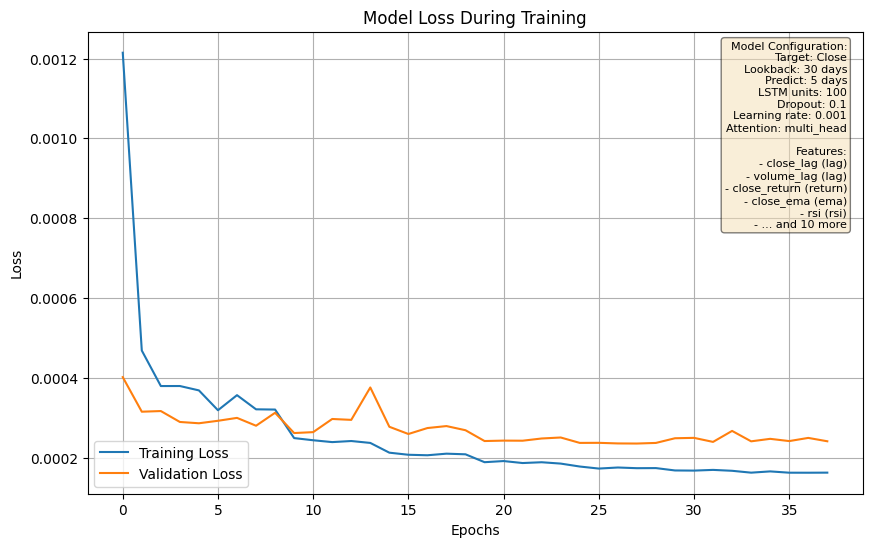

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step

===== TEST PREDICTION DATES =====
Number of test sequences: 839
First 3 test sequence end dates: [Timestamp('2020-03-04 00:00:00'), Timestamp('2020-03-05 00:00:00'), Timestamp('2020-03-06 00:00:00')]

Model Performance Metrics:
day_1: MSE=0.004248, MAE=0.044083, RMSE=0.065179
day_2: MSE=0.004375, MAE=0.044869, RMSE=0.066146
day_3: MSE=0.004385, MAE=0.044489, RMSE=0.066221
day_4: MSE=0.004860, MAE=0.047690, RMSE=0.069715
day_5: MSE=0.005089, MAE=0.048920, RMSE=0.071334

===== DATE ALIGNMENT FOR PLOTTING =====
Number of test points: 839
First 3 dates in prediction sequence: [Timestamp('2020-03-04 00:00:00'), Timestamp('2020-03-05 00:00:00'), Timestamp('2020-03-06 00:00:00')]

Day 1 prediction dates:
First 3 target dates: [Timestamp('2020-03-05 00:00:00'), Timestamp('2020-03-06 00:00:00'), Timestamp('2020-03-09 00:00:00')]

Day 2 prediction dates:
First 3 target dates: [Timestamp('2020-03-06 00:00:00'), Timestamp('2020-03-09 00:00:00'), Timestamp(

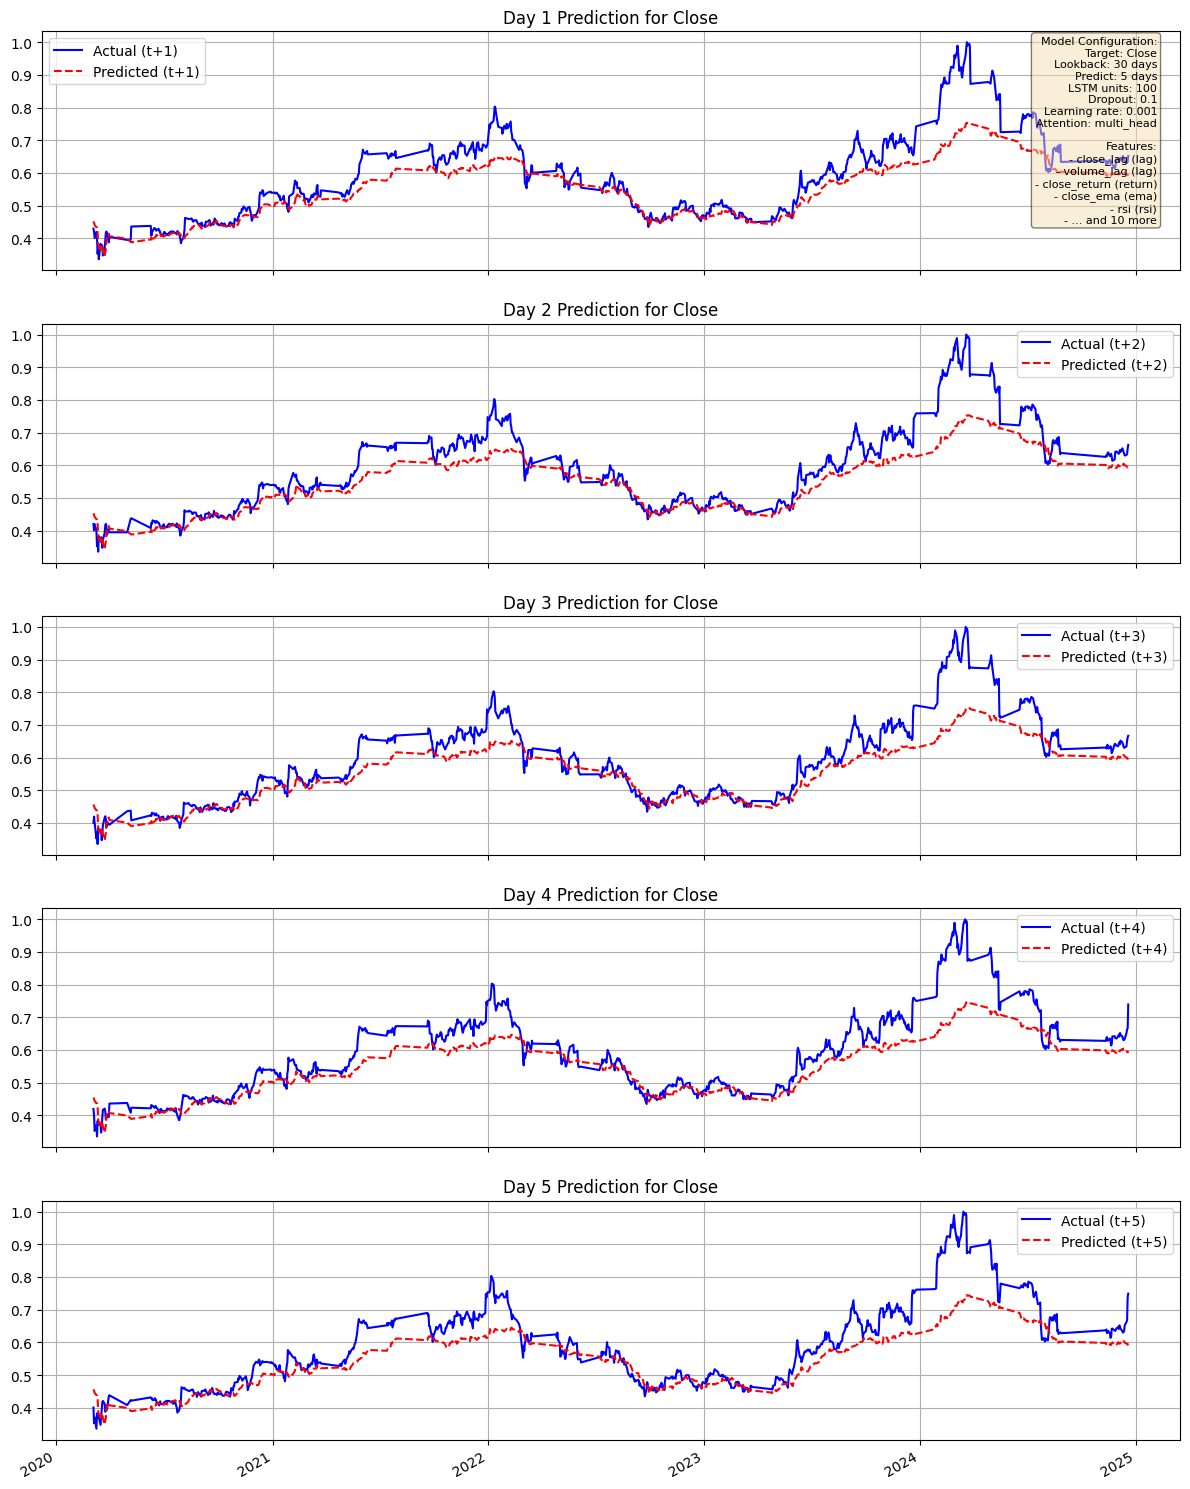

Metrics saved to lstm_attention_metrics_20250310-013345.csv


In [6]:
main()